In [6]:
import pandas as pd
import os

# Define the folder path for Texas electricity prices data
texas_price_folder = '/Users/aashrithasankineni/Downloads/texas_electricity_prices'

# Initialize a list to hold each file's data
texas_price_dfs = []

# Load each CSV file in the texas_electricity_prices folder
if os.path.exists(texas_price_folder):
    for filename in os.listdir(texas_price_folder):
        if filename.endswith('.csv'):
            file_path = os.path.join(texas_price_folder, filename)
            texas_price_dfs.append(pd.read_csv(file_path, delimiter=',', on_bad_lines='skip'))
            print(f"Loaded data from {filename}")
else:
    print(f"Folder not found: {texas_price_folder}")

# Concatenate all dataframes if any files were loaded
if texas_price_dfs:
    texas_price_df = pd.concat(texas_price_dfs, ignore_index=True)
    print("Combined Texas Electricity Prices Data:\n", texas_price_df.head())
else:
    print("No Texas electricity prices data loaded.")


Loaded data from ercot_lmp_rt_15min_hubs_2021Q1.csv
Loaded data from ercot_lmp_rt_15min_hubs_2023Q3.csv
Loaded data from ercot_lmp_rt_15min_hubs_2023Q2.csv
Loaded data from ercot_lmp_rt_15min_hubs_2021Q2.csv
Loaded data from ercot_lmp_rt_15min_hubs_2023Q1.csv
Loaded data from ercot_lmp_rt_15min_hubs_2021Q3.csv
Loaded data from ercot_lmp_rt_15min_hubs_2023Q4.csv
Loaded data from ercot_lmp_rt_15min_hubs_2021Q4.csv
Loaded data from ercot_lmp_rt_15min_hubs_2020Q2.csv
Loaded data from ercot_lmp_rt_15min_hubs_2020Q3.csv
Loaded data from ercot_lmp_rt_15min_hubs_2022Q1.csv
Loaded data from ercot_lmp_rt_15min_hubs_2022Q3.csv
Loaded data from ercot_lmp_rt_15min_hubs_2020Q1.csv
Loaded data from ercot_lmp_rt_15min_hubs_2024Q4.csv
Loaded data from ercot_lmp_rt_15min_hubs_2022Q2.csv
Loaded data from ercot_lmp_rt_15min_hubs_2020Q4.csv
Loaded data from ercot_lmp_rt_15min_hubs_2024Q1.csv
Loaded data from ercot_lmp_rt_15min_hubs_2024Q3.csv
Loaded data from ercot_lmp_rt_15min_hubs_2024Q2.csv
Loaded data 

In [7]:
import os
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Path to the Texas electricity prices folder
texas_folder_path = '/Users/aashrithasankineni/Downloads/texas_electricity_prices'

# Dictionary to store ARIMA-prepared dataframes
arima_ready_data_texas = {}

# ARIMA-specific preprocessing function
def preprocess_for_arima(df, target_column):
    df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
    df.set_index('datetime', inplace=True)
    
    df[target_column] = pd.to_numeric(df[target_column], errors='coerce')
    df[target_column] = df[target_column].interpolate(method='linear').ffill().bfill()
    
    result = adfuller(df[target_column].dropna())
    if result[1] > 0.05:
        df[target_column] = df[target_column].diff().dropna()
    
    return df

# Process each Texas file for ARIMA with flexible column handling
for filename in os.listdir(texas_folder_path):
    file_path = os.path.join(texas_folder_path, filename)
    
    # Process only .csv files
    if filename.endswith('.csv'):
        try:
            # Load file and inspect columns
            df = pd.read_csv(file_path, skiprows=3)
            
            # Check for 'UTC Timestamp (Interval Ending)' as datetime
            datetime_col = 'UTC Timestamp (Interval Ending)'
            
            # Dynamically identify an LMP column if 'A - West LMP' is not available
            lmp_columns = [col for col in df.columns if 'LMP' in col]
            
            if datetime_col in df.columns and lmp_columns:
                # Use the first available LMP column
                selected_lmp_col = lmp_columns[0]
                df = df[[datetime_col, selected_lmp_col]]
                df.columns = ['datetime', 'marginal_price']
                
                # Preprocess the data for ARIMA
                processed_df = preprocess_for_arima(df, 'marginal_price')
                arima_ready_data_texas[file_path] = processed_df
                print(f"ARIMA preprocessing completed for {filename} using '{selected_lmp_col}'")
            else:
                print(f"Skipping {filename} due to missing required columns.")
                print(f"Available columns in {filename}: {df.columns.tolist()}")
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Display processed data for verification
for name, df in arima_ready_data_texas.items():
    print(f"\nProcessed data for ARIMA in {name}:\n", df.head())


ARIMA preprocessing completed for ercot_lmp_rt_15min_hubs_2021Q1.csv using 'Bus average LMP'
ARIMA preprocessing completed for ercot_lmp_rt_15min_hubs_2023Q3.csv using 'Bus average LMP'
ARIMA preprocessing completed for ercot_lmp_rt_15min_hubs_2023Q2.csv using 'Bus average LMP'
ARIMA preprocessing completed for ercot_lmp_rt_15min_hubs_2021Q2.csv using 'Bus average LMP'
ARIMA preprocessing completed for ercot_lmp_rt_15min_hubs_2023Q1.csv using 'Bus average LMP'
ARIMA preprocessing completed for ercot_lmp_rt_15min_hubs_2021Q3.csv using 'Bus average LMP'
ARIMA preprocessing completed for ercot_lmp_rt_15min_hubs_2023Q4.csv using 'Bus average LMP'
ARIMA preprocessing completed for ercot_lmp_rt_15min_hubs_2021Q4.csv using 'Bus average LMP'
ARIMA preprocessing completed for ercot_lmp_rt_15min_hubs_2020Q2.csv using 'Bus average LMP'
ARIMA preprocessing completed for ercot_lmp_rt_15min_hubs_2020Q3.csv using 'Bus average LMP'
ARIMA preprocessing completed for ercot_lmp_rt_15min_hubs_2022Q1.csv u

In [8]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Normalize the data using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# Corrected paths and preprocessing
directory = "/Users/aashrithasankineni/Downloads/texas_electricity_prices/"
file_paths = [
    f"{directory}ercot_lmp_rt_15min_hubs_2022Q1.csv",
    f"{directory}ercot_lmp_rt_15min_hubs_2022Q2.csv",
    f"{directory}ercot_lmp_rt_15min_hubs_2022Q3.csv",
    f"{directory}ercot_lmp_rt_15min_hubs_2022Q4.csv",
    f"{directory}ercot_lmp_rt_15min_hubs_2023Q1.csv",
    f"{directory}ercot_lmp_rt_15min_hubs_2023Q2.csv",
    f"{directory}ercot_lmp_rt_15min_hubs_2023Q3.csv",
    f"{directory}ercot_lmp_rt_15min_hubs_2023Q4.csv",
    f"{directory}ercot_lmp_rt_15min_hubs_2024Q1.csv",
    f"{directory}ercot_lmp_rt_15min_hubs_2024Q2.csv",
    f"{directory}ercot_lmp_rt_15min_hubs_2024Q3.csv",
    f"{directory}ercot_lmp_rt_15min_hubs_2024Q4.csv",
]

# Combine all data
dataframes = []
for file in file_paths:
    df = pd.read_csv(file, skiprows=3)
    dataframes.append(df)
data_combined_texas = pd.concat(dataframes, ignore_index=True)

# Rename and preprocess datetime
data_combined_texas.rename(columns={'UTC Timestamp (Interval Ending)': 'datetime'}, inplace=True)
data_combined_texas['datetime'] = pd.to_datetime(data_combined_texas['datetime'])
data_combined_texas.set_index('datetime', inplace=True)

# Resample to hourly averages
hourly_prices_texas = data_combined_texas['Bus average LMP'].resample('h').mean()

# Clip outliers
hourly_prices_texas = hourly_prices_texas.clip(
    lower=hourly_prices_texas.quantile(0.01), 
    upper=hourly_prices_texas.quantile(0.99)
)

# Normalize the data
scaler = MinMaxScaler()
hourly_prices_scaled = pd.Series(
    scaler.fit_transform(hourly_prices_texas.values.reshape(-1, 1)).flatten(),
    index=hourly_prices_texas.index
)

# Define SARIMA parameters
order = (1, 0, 1)
seasonal_order = (0, 1, 1, 24)

# Fit the SARIMA model
sarima_model = SARIMAX(
    hourly_prices_scaled,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_fit = sarima_model.fit(disp=False, maxiter=1000)

# Forecast for 2025
steps = 365 * 24  # Total number of hours in 2025
forecast = sarima_fit.get_forecast(steps=steps)
forecast_df = forecast.summary_frame()

# Reverse scaling
forecast_df['mean'] = scaler.inverse_transform(forecast_df['mean'].values.reshape(-1, 1)).flatten()

# Add datetime index for 2025
forecast_start = pd.Timestamp("2025-01-01 00:00:00")
forecast_end = pd.Timestamp("2025-12-31 23:00:00")
forecast_df['datetime'] = pd.date_range(start=forecast_start, end=forecast_end, freq='h')
forecast_df.set_index('datetime', inplace=True)

# Save the forecast to CSV
forecast_df[['mean']].to_csv(f"{directory}forecast_2025_hourly.csv")
print("Hourly forecast for 2025 saved to 'forecast_2025_hourly.csv'")


Hourly forecast for 2025 saved to 'forecast_2025_hourly.csv'


In [9]:
import plotly.graph_objects as go

# Load the forecasted data for Texas
forecast_2025 = pd.read_csv('/Users/aashrithasankineni/Downloads/texas_electricity_prices/forecast_2025_hourly.csv', index_col='datetime', parse_dates=True)

# Hourly Forecast Plot
fig_hourly = go.Figure()
fig_hourly.add_trace(go.Scatter(
    x=forecast_2025.index,
    y=forecast_2025['mean'],  # Use 'mean' for forecasted prices
    mode='lines',
    name='Hourly Forecast'
))
fig_hourly.update_layout(
    title='Hourly Electricity Price Forecast for Texas (2025, SARIMA)',
    xaxis_title='Datetime (UTC)',
    yaxis_title='Electricity Price (USD)',
    template='plotly_dark',
    legend=dict(x=0, y=1)
)
fig_hourly.show()

# Daily Forecast Plot
daily_forecast = forecast_2025['mean'].resample('D').mean()
fig_daily = go.Figure()
fig_daily.add_trace(go.Scatter(
    x=daily_forecast.index,
    y=daily_forecast,
    mode='lines',
    name='Daily Forecast',
    line=dict(color='orange')
))
fig_daily.update_layout(
    title='Daily Electricity Price Forecast for Texas (2025, SARIMA)',
    xaxis_title='Date',
    yaxis_title='Average Electricity Price (USD)',
    template='plotly_dark',
    legend=dict(x=0, y=1)
)
fig_daily.show()

# Monthly Forecast Plot
monthly_forecast = forecast_2025['mean'].resample('M').mean()
fig_monthly = go.Figure()
fig_monthly.add_trace(go.Scatter(
    x=monthly_forecast.index,
    y=monthly_forecast,
    mode='lines',
    name='Monthly Forecast',
    line=dict(color='green')
))
fig_monthly.update_layout(
    title='Monthly Electricity Price Forecast for Texas (2025, SARIMA)',
    xaxis_title='Month',
    yaxis_title='Average Electricity Price (USD)',
    template='plotly_dark',
    legend=dict(x=0, y=1)
)
fig_monthly.show()


/var/folders/v8/hd7794fx5371lx6nxszm2j7w0000gn/T/ipykernel_1335/3016743189.py:43: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [18]:
import pandas as pd
import os

# Define the base folder path directly to the Downloads directory
texas_carbon_folder = '/Users/aashrithasankineni/Downloads'

# Specific folder name for Texas carbon footprint within Downloads
texas_carbon_subfolder = 'texas_carbon_footprint'
texas_carbon_full_path = os.path.join(texas_carbon_folder, texas_carbon_subfolder)

# Initialize a list to hold each file's data
texas_carbon_dfs = []

# Load each CSV file in the texas_carbon_footprint folder
if os.path.exists(texas_carbon_full_path):
    for filename in os.listdir(texas_carbon_full_path):
        if filename.endswith('.csv'):  # Ensure only CSV files are processed
            file_path = os.path.join(texas_carbon_full_path, filename)
            try:
                # Read the CSV file
                texas_carbon_dfs.append(pd.read_csv(file_path, delimiter=',', on_bad_lines='skip'))
                print(f"Loaded data from {filename}")
            except Exception as e:
                print(f"Error loading {filename}: {e}")
else:
    print(f"Folder not found: {texas_carbon_full_path}")

# Concatenate all dataframes if any files were loaded
if texas_carbon_dfs:
    texas_carbon_df = pd.concat(texas_carbon_dfs, ignore_index=True)
    print("Combined Texas Carbon Footprint Data:\n", texas_carbon_df.head())
else:
    print("No Texas carbon footprint data loaded.")


Loaded data from US-TEX-ERCO_2023_hourly.csv
Loaded data from US-TEX-ERCO_2021_hourly.csv
Loaded data from US-TEX-ERCO_2022_hourly.csv
Combined Texas Carbon Footprint Data:
         Datetime (UTC) Country                                    Zone Name  \
0  2023-01-01 00:00:00     USA  Electric Reliability Council of Texas, Inc.   
1  2023-01-01 01:00:00     USA  Electric Reliability Council of Texas, Inc.   
2  2023-01-01 02:00:00     USA  Electric Reliability Council of Texas, Inc.   
3  2023-01-01 03:00:00     USA  Electric Reliability Council of Texas, Inc.   
4  2023-01-01 04:00:00     USA  Electric Reliability Council of Texas, Inc.   

       Zone Id  Carbon Intensity gCO₂eq/kWh (direct)  \
0  US-TEX-ERCO                                269.82   
1  US-TEX-ERCO                                224.47   
2  US-TEX-ERCO                                211.52   
3  US-TEX-ERCO                                202.00   
4  US-TEX-ERCO                                188.45   

   Carbon Inte

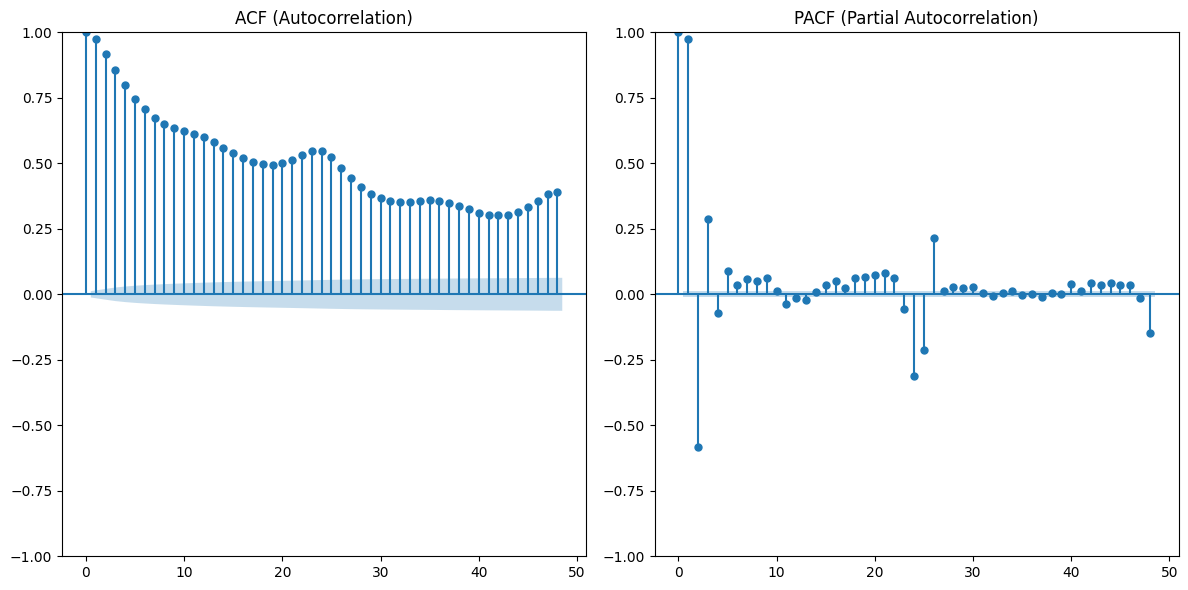

Fitting SARIMA model...
                                        SARIMAX Results                                         
Dep. Variable:     Carbon Intensity gCO₂eq/kWh (direct)   No. Observations:                26280
Model:                   SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood              -99763.376
Date:                                  Sun, 01 Dec 2024   AIC                         199536.751
Time:                                          13:14:25   BIC                         199577.624
Sample:                                      01-01-2021   HQIC                        199549.950
                                           - 12-31-2023                                         
Covariance Type:                                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3139      0.008     40.25

In [19]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Load datasets for Texas (update file paths for your Texas data)
data_2021 = pd.read_csv('/Users/aashrithasankineni/Downloads/texas_carbon_footprint/US-TEX-ERCO_2021_hourly.csv')
data_2022 = pd.read_csv('/Users/aashrithasankineni/Downloads/texas_carbon_footprint/US-TEX-ERCO_2022_hourly.csv')
data_2023 = pd.read_csv('/Users/aashrithasankineni/Downloads/texas_carbon_footprint/US-TEX-ERCO_2023_hourly.csv')

# Combine datasets
data_combined = pd.concat([data_2021, data_2022, data_2023], ignore_index=True)

# Convert Datetime to pandas datetime and set as index
data_combined['Datetime (UTC)'] = pd.to_datetime(data_combined['Datetime (UTC)'])
data_combined.set_index('Datetime (UTC)', inplace=True)

# Explicitly set frequency for time index (hourly)
data_combined = data_combined.asfreq('h')

# Select the target column
carbon_intensity = data_combined['Carbon Intensity gCO₂eq/kWh (direct)']

# Plot ACF and PACF for non-seasonal components
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(carbon_intensity.dropna(), lags=48, ax=plt.gca(), title="ACF (Autocorrelation)")
plt.subplot(122)
plot_pacf(carbon_intensity.dropna(), lags=48, ax=plt.gca(), title="PACF (Partial Autocorrelation)")
plt.tight_layout()
plt.show()

# Fit a SARIMA model with seasonal components
# Seasonal order (P, D, Q, S): Choose S=24 for hourly seasonality
print("Fitting SARIMA model...")
sarima_model = SARIMAX(
    carbon_intensity,
    order=(1, 1, 1),  # Non-seasonal (p, d, q)
    seasonal_order=(1, 1, 1, 24),  # Seasonal (P, D, Q, S)
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_fit = sarima_model.fit(disp=False)

# Display model summary
print(sarima_fit.summary())

# Forecast for 2024 (8760 hours for a leap year)
forecast_steps = 8760  # Number of hours in 2024
future_dates = pd.date_range(start='2024-01-01 00:00:00', periods=forecast_steps, freq='h')
forecast_2024 = sarima_fit.forecast(steps=forecast_steps)

# Create a DataFrame for forecasted results
forecast_df = pd.DataFrame({'Datetime (UTC)': future_dates, 'Forecast': forecast_2024})
forecast_df.set_index('Datetime (UTC)', inplace=True)

# Save forecast to a CSV file
forecast_df.to_csv('/Users/aashrithasankineni/Downloads/texas_carbon_footprint/forecast_2024_hourly_sarima.csv')

# Display a preview of the forecast
print("Hourly Forecast Preview (2024):")
print(forecast_df.head())


In [20]:
import plotly.graph_objects as go

# Create a dynamic graph using Plotly for Texas Carbon Intensity Forecast
fig = go.Figure()

# Add hourly forecast to the graph
fig.add_trace(go.Scatter(
    x=forecast_df.index,
    y=forecast_df['Forecast'],
    mode='lines',
    name='Hourly Forecast',
    line=dict(color='blue')
))

# Customize layout
fig.update_layout(
    title='Hourly Carbon Intensity Forecast for Texas (2024)',
    xaxis_title='Datetime (UTC)',
    yaxis_title='Carbon Intensity (gCO₂eq/kWh)',
    template='plotly_dark',
    legend=dict(x=0, y=1),
)

# Show the graph
fig.show()


In [8]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler

# Define the directory and file paths for the relevant years
directory = "/Users/aashrithasankineni/Downloads/texas_electricity_prices/"
file_paths = [
    f"{directory}ercot_lmp_rt_15min_hubs_2020Q1.csv",
    f"{directory}ercot_lmp_rt_15min_hubs_2020Q2.csv",
    f"{directory}ercot_lmp_rt_15min_hubs_2020Q3.csv",
    f"{directory}ercot_lmp_rt_15min_hubs_2020Q4.csv",
    f"{directory}ercot_lmp_rt_15min_hubs_2021Q1.csv",
    f"{directory}ercot_lmp_rt_15min_hubs_2021Q2.csv",
    f"{directory}ercot_lmp_rt_15min_hubs_2021Q3.csv",
    f"{directory}ercot_lmp_rt_15min_hubs_2021Q4.csv",
    f"{directory}ercot_lmp_rt_15min_hubs_2022Q1.csv",
    f"{directory}ercot_lmp_rt_15min_hubs_2022Q2.csv",
    f"{directory}ercot_lmp_rt_15min_hubs_2022Q3.csv",
    f"{directory}ercot_lmp_rt_15min_hubs_2022Q4.csv",
    f"{directory}ercot_lmp_rt_15min_hubs_2023Q1.csv",
    f"{directory}ercot_lmp_rt_15min_hubs_2023Q2.csv",
    f"{directory}ercot_lmp_rt_15min_hubs_2023Q3.csv",
    f"{directory}ercot_lmp_rt_15min_hubs_2023Q4.csv",
]

# Combine all data for 2020-2023
dataframes = []
for file in file_paths:
    df = pd.read_csv(file, skiprows=3)
    dataframes.append(df)
data_combined = pd.concat(dataframes, ignore_index=True)

# Rename and preprocess datetime
data_combined.rename(columns={'UTC Timestamp (Interval Ending)': 'datetime'}, inplace=True)
data_combined['datetime'] = pd.to_datetime(data_combined['datetime'])
data_combined.set_index('datetime', inplace=True)

# Resample to hourly averages
hourly_prices = data_combined['Bus average LMP'].resample('h').mean()

# Clip outliers
hourly_prices = hourly_prices.clip(
    lower=hourly_prices.quantile(0.01), 
    upper=hourly_prices.quantile(0.99)
)

# Normalize the data
scaler = MinMaxScaler()
hourly_prices_scaled = pd.Series(
    scaler.fit_transform(hourly_prices.values.reshape(-1, 1)).flatten(),
    index=hourly_prices.index
)

# Define SARIMA parameters
order = (1, 0, 1)
seasonal_order = (0, 1, 1, 24)

# Fit the SARIMA model
sarima_model = SARIMAX(
    hourly_prices_scaled,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_fit = sarima_model.fit(disp=False, maxiter=1000)

# Forecast for 2024
forecast_start = pd.Timestamp("2024-01-01 00:00:00")
forecast_end = pd.Timestamp("2024-12-31 23:00:00")
forecast_dates = pd.date_range(start=forecast_start, end=forecast_end, freq='h')

# Forecast steps must match the total number of forecast dates
steps = len(forecast_dates)
forecast = sarima_fit.get_forecast(steps=steps)
forecast_df = forecast.summary_frame()

# Reverse scaling
forecast_df['mean'] = scaler.inverse_transform(forecast_df['mean'].values.reshape(-1, 1)).flatten()

# Add datetime index for 2024
forecast_df['datetime'] = forecast_dates
forecast_df.set_index('datetime', inplace=True)

# Save the forecast to CSV
forecast_df[['mean']].to_csv(f"{directory}forecast_2024_hourly.csv")
print("Hourly forecast for 2024 saved to 'forecast_2024_hourly.csv'")


Hourly forecast for 2024 saved to 'forecast_2024_hourly.csv'


In [7]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define the directory and file paths
actual_file_paths = [
    "/Users/aashrithasankineni/Downloads/texas_electricity_prices/ercot_lmp_rt_15min_hubs_2024Q1.csv",
    "/Users/aashrithasankineni/Downloads/texas_electricity_prices/ercot_lmp_rt_15min_hubs_2024Q2.csv",
    "/Users/aashrithasankineni/Downloads/texas_electricity_prices/ercot_lmp_rt_15min_hubs_2024Q3.csv",
    "/Users/aashrithasankineni/Downloads/texas_electricity_prices/ercot_lmp_rt_15min_hubs_2024Q4.csv"
]
forecast_file_path = "/Users/aashrithasankineni/Downloads/texas_electricity_prices/forecast_2024_hourly.csv"

# Load and combine actual data for all quarters
actual_dataframes = []
for file in actual_file_paths:
    df = pd.read_csv(file, skiprows=3)
    actual_dataframes.append(df)
actual_combined = pd.concat(actual_dataframes, ignore_index=True)

# Preprocess actual data
actual_combined.rename(columns={'UTC Timestamp (Interval Ending)': 'datetime'}, inplace=True)
actual_combined['datetime'] = pd.to_datetime(actual_combined['datetime'])
actual_combined.set_index('datetime', inplace=True)

# Calculate the mean of all relevant regions in the actual data
region_columns = ['Bus average LMP', 'Houston LMP', 'Hub average LMP', 'North LMP', 'Panhandle LMP', 'South LMP', 'West LMP']
actual_combined['mean_actual'] = actual_combined[region_columns].mean(axis=1)

# Resample to hourly averages to match the forecast
actual_hourly = actual_combined['mean_actual'].resample('h').mean()

# Handle missing values in actual data
actual_hourly = actual_hourly.interpolate(method='time')  # Interpolate missing values

# Load forecast data
forecast_data = pd.read_csv(forecast_file_path)
forecast_data['datetime'] = pd.to_datetime(forecast_data['datetime'])
forecast_data.set_index('datetime', inplace=True)

# Merge actual and forecast data on the datetime index
merged_data = pd.merge(actual_hourly, forecast_data[['mean']], left_index=True, right_index=True, how='inner')

# Rename columns for clarity
merged_data.rename(columns={'mean': 'predicted', 'mean_actual': 'actual'}, inplace=True)

# Drop remaining NaN values if any
merged_data = merged_data.dropna()

# Calculate metrics
mae = mean_absolute_error(merged_data['actual'], merged_data['predicted'])
mse = mean_squared_error(merged_data['actual'], merged_data['predicted'])
r2 = r2_score(merged_data['actual'], merged_data['predicted'])

# Print the metrics
metrics = {
    "Mean Absolute Error (MAE)": mae,
    "Mean Squared Error (MSE)": mse,
    "R-squared (R²)": r2,
}

print("Metrics for Actual and Predicted 2024 Data:")
print(metrics)


Metrics for Actual and Predicted 2024 Data:
{'Mean Absolute Error (MAE)': np.float64(17.91586818670322), 'Mean Squared Error (MSE)': np.float64(5737.632822328188), 'R-squared (R²)': -0.024563070857462677}


In [9]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler

# Define the directory and file paths for the relevant years
directory = "/Users/aashrithasankineni/Downloads/texas_electricity_prices/"
file_paths = [
    f"{directory}ercot_lmp_rt_15min_hubs_2020Q1.csv",
    f"{directory}ercot_lmp_rt_15min_hubs_2020Q2.csv",
    f"{directory}ercot_lmp_rt_15min_hubs_2020Q3.csv",
    f"{directory}ercot_lmp_rt_15min_hubs_2020Q4.csv",
    f"{directory}ercot_lmp_rt_15min_hubs_2021Q1.csv",
    f"{directory}ercot_lmp_rt_15min_hubs_2021Q2.csv",
    f"{directory}ercot_lmp_rt_15min_hubs_2021Q3.csv",
    f"{directory}ercot_lmp_rt_15min_hubs_2021Q4.csv",
    f"{directory}ercot_lmp_rt_15min_hubs_2022Q1.csv",
    f"{directory}ercot_lmp_rt_15min_hubs_2022Q2.csv",
    f"{directory}ercot_lmp_rt_15min_hubs_2022Q3.csv",
    f"{directory}ercot_lmp_rt_15min_hubs_2022Q4.csv",
    f"{directory}ercot_lmp_rt_15min_hubs_2023Q1.csv",
    f"{directory}ercot_lmp_rt_15min_hubs_2023Q2.csv",
    f"{directory}ercot_lmp_rt_15min_hubs_2023Q3.csv",
    f"{directory}ercot_lmp_rt_15min_hubs_2023Q4.csv",
]

# Combine all data for 2020-2023
dataframes = []
for file in file_paths:
    df = pd.read_csv(file, skiprows=3)
    dataframes.append(df)
data_combined = pd.concat(dataframes, ignore_index=True)

# Rename and preprocess datetime
data_combined.rename(columns={'UTC Timestamp (Interval Ending)': 'datetime'}, inplace=True)
data_combined['datetime'] = pd.to_datetime(data_combined['datetime'])
data_combined.set_index('datetime', inplace=True)

# Calculate the mean of relevant regions
region_columns = ['Bus average LMP', 'Houston LMP', 'Hub average LMP', 'North LMP', 'Panhandle LMP', 'South LMP', 'West LMP']
data_combined['mean_price'] = data_combined[region_columns].mean(axis=1)

# Resample to hourly averages
hourly_prices = data_combined['mean_price'].resample('h').mean()

# Clip outliers
hourly_prices = hourly_prices.clip(
    lower=hourly_prices.quantile(0.01), 
    upper=hourly_prices.quantile(0.99)
)

# Normalize the data
scaler = MinMaxScaler()
hourly_prices_scaled = pd.Series(
    scaler.fit_transform(hourly_prices.values.reshape(-1, 1)).flatten(),
    index=hourly_prices.index
)

# Define SARIMA parameters
order = (1, 0, 1)
seasonal_order = (0, 1, 1, 24)

# Fit the SARIMA model
sarima_model = SARIMAX(
    hourly_prices_scaled,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_fit = sarima_model.fit(disp=False, maxiter=1000)

# Forecast for 2024
forecast_start = pd.Timestamp("2024-01-01 00:00:00")
forecast_end = pd.Timestamp("2024-12-31 23:00:00")
forecast_dates = pd.date_range(start=forecast_start, end=forecast_end, freq='h')

# Forecast steps must match the total number of forecast dates
steps = len(forecast_dates)
forecast = sarima_fit.get_forecast(steps=steps)
forecast_df = forecast.summary_frame()

# Reverse scaling
forecast_df['mean'] = scaler.inverse_transform(forecast_df['mean'].values.reshape(-1, 1)).flatten()

# Add datetime index for 2024
forecast_df['datetime'] = forecast_dates
forecast_df.set_index('datetime', inplace=True)

# Save the forecast to CSV
forecast_df[['mean']].to_csv(f"{directory}forecast_2024_hourly.csv")
print("Hourly forecast for 2024 saved to 'forecast_2024_hourly.csv'")


Hourly forecast for 2024 saved to 'forecast_2024_hourly.csv'


In [11]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define the directory and file paths
actual_file_paths = [
    "/Users/aashrithasankineni/Downloads/texas_electricity_prices/ercot_lmp_rt_15min_hubs_2024Q1.csv",
    "/Users/aashrithasankineni/Downloads/texas_electricity_prices/ercot_lmp_rt_15min_hubs_2024Q2.csv",
    "/Users/aashrithasankineni/Downloads/texas_electricity_prices/ercot_lmp_rt_15min_hubs_2024Q3.csv",
    "/Users/aashrithasankineni/Downloads/texas_electricity_prices/ercot_lmp_rt_15min_hubs_2024Q4.csv"
]
forecast_file_path = "/Users/aashrithasankineni/Downloads/texas_electricity_prices/forecast_2024_hourly.csv"

# Load and combine actual data for all quarters
actual_dataframes = []
for file in actual_file_paths:
    df = pd.read_csv(file, skiprows=3)
    actual_dataframes.append(df)
actual_combined = pd.concat(actual_dataframes, ignore_index=True)

# Preprocess actual data
actual_combined.rename(columns={'UTC Timestamp (Interval Ending)': 'datetime'}, inplace=True)
actual_combined['datetime'] = pd.to_datetime(actual_combined['datetime'])
actual_combined.set_index('datetime', inplace=True)

# Calculate the mean of relevant regions
region_columns = ['Bus average LMP', 'Houston LMP', 'Hub average LMP', 'North LMP', 'Panhandle LMP', 'South LMP', 'West LMP']
actual_combined['mean_actual'] = actual_combined[region_columns].mean(axis=1)

# Resample to hourly averages to match the forecast
actual_hourly = actual_combined['mean_actual'].resample('h').mean()

# Handle missing values in actual data
actual_hourly = actual_hourly.interpolate(method='time')  # Interpolate missing values

# Load forecast data
forecast_data = pd.read_csv(forecast_file_path)
forecast_data['datetime'] = pd.to_datetime(forecast_data['datetime'])
forecast_data.set_index('datetime', inplace=True)

# Merge actual and forecast data on the datetime index
merged_data = pd.merge(actual_hourly, forecast_data[['mean']], left_index=True, right_index=True, how='inner')

# Rename columns for clarity
merged_data.rename(columns={'mean': 'predicted', 'mean_actual': 'actual'}, inplace=True)

# Drop remaining NaN values if any
merged_data = merged_data.dropna()

# Calculate metrics
mae = mean_absolute_error(merged_data['actual'], merged_data['predicted'])
mse = mean_squared_error(merged_data['actual'], merged_data['predicted'])
r2 = r2_score(merged_data['actual'], merged_data['predicted'])

# Print the metrics
metrics = {
    "Mean Absolute Error (MAE)": mae,
    "Mean Squared Error (MSE)": mse,
    "R-squared (R²)": r2,
}

print("Metrics for Actual and Predicted 2024 Data:")
print(metrics)


Metrics for Actual and Predicted 2024 Data:
{'Mean Absolute Error (MAE)': np.float64(17.928313248977414), 'Mean Squared Error (MSE)': np.float64(5735.754098074486), 'R-squared (R²)': -0.02422758903939015}


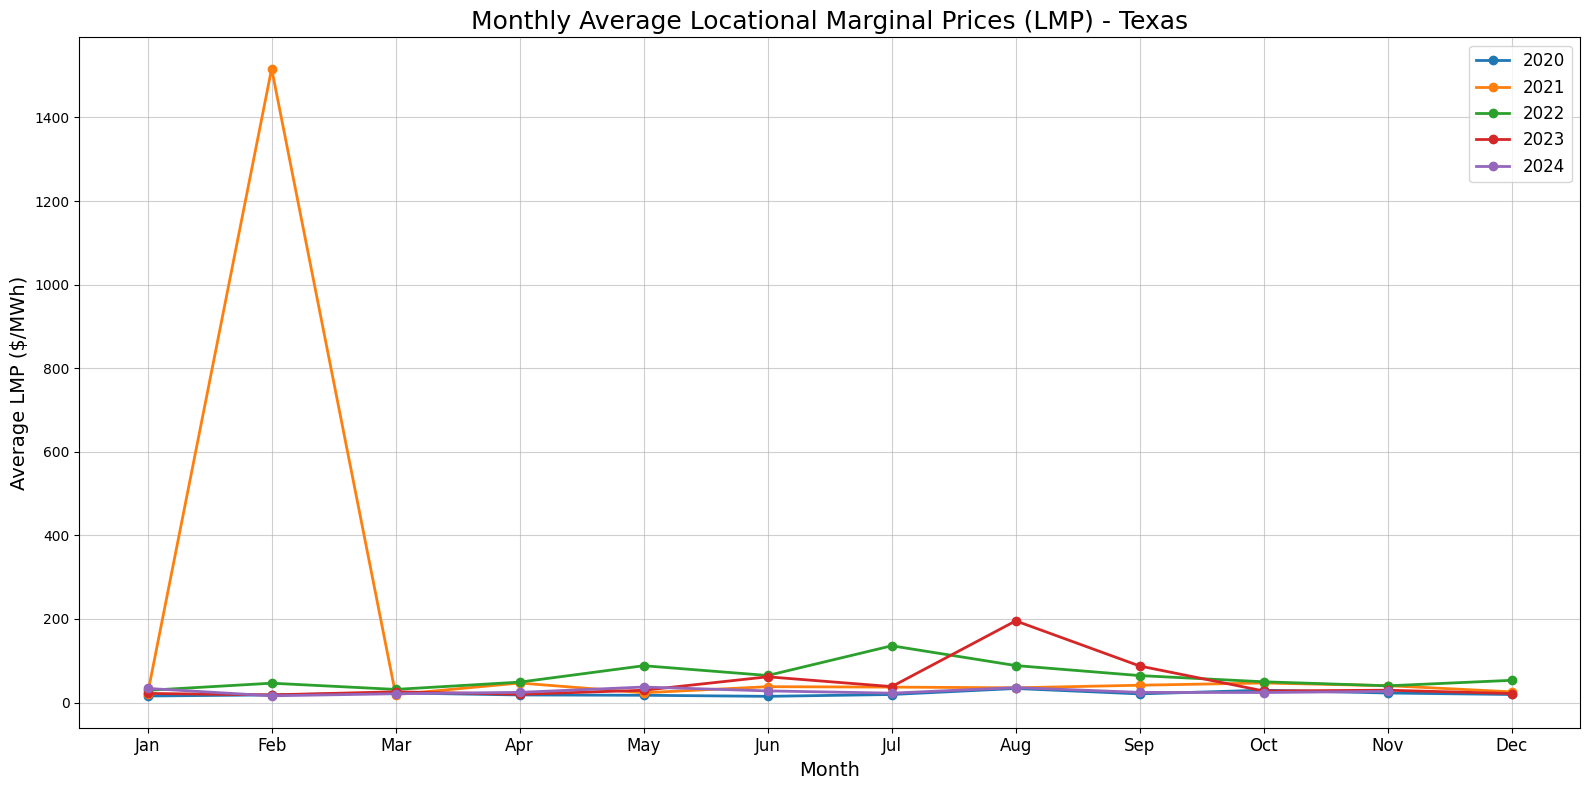

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# File paths for Texas data
files_texas = [
    "/Users/aashrithasankineni/Downloads/texas_electricity_prices/ercot_lmp_rt_15min_hubs_2020Q1.csv",
    "/Users/aashrithasankineni/Downloads/texas_electricity_prices/ercot_lmp_rt_15min_hubs_2020Q2.csv",
    "/Users/aashrithasankineni/Downloads/texas_electricity_prices/ercot_lmp_rt_15min_hubs_2020Q3.csv",
    "/Users/aashrithasankineni/Downloads/texas_electricity_prices/ercot_lmp_rt_15min_hubs_2020Q4.csv",
    "/Users/aashrithasankineni/Downloads/texas_electricity_prices/ercot_lmp_rt_15min_hubs_2021Q1.csv",
    "/Users/aashrithasankineni/Downloads/texas_electricity_prices/ercot_lmp_rt_15min_hubs_2021Q2.csv",
    "/Users/aashrithasankineni/Downloads/texas_electricity_prices/ercot_lmp_rt_15min_hubs_2021Q3.csv",
    "/Users/aashrithasankineni/Downloads/texas_electricity_prices/ercot_lmp_rt_15min_hubs_2021Q4.csv",
    "/Users/aashrithasankineni/Downloads/texas_electricity_prices/ercot_lmp_rt_15min_hubs_2022Q1.csv",
    "/Users/aashrithasankineni/Downloads/texas_electricity_prices/ercot_lmp_rt_15min_hubs_2022Q2.csv",
    "/Users/aashrithasankineni/Downloads/texas_electricity_prices/ercot_lmp_rt_15min_hubs_2022Q3.csv",
    "/Users/aashrithasankineni/Downloads/texas_electricity_prices/ercot_lmp_rt_15min_hubs_2022Q4.csv",
    "/Users/aashrithasankineni/Downloads/texas_electricity_prices/ercot_lmp_rt_15min_hubs_2023Q1.csv",
    "/Users/aashrithasankineni/Downloads/texas_electricity_prices/ercot_lmp_rt_15min_hubs_2023Q2.csv",
    "/Users/aashrithasankineni/Downloads/texas_electricity_prices/ercot_lmp_rt_15min_hubs_2023Q3.csv",
    "/Users/aashrithasankineni/Downloads/texas_electricity_prices/ercot_lmp_rt_15min_hubs_2023Q4.csv",
    "/Users/aashrithasankineni/Downloads/texas_electricity_prices/ercot_lmp_rt_15min_hubs_2024Q1.csv",
    "/Users/aashrithasankineni/Downloads/texas_electricity_prices/ercot_lmp_rt_15min_hubs_2024Q2.csv",
    "/Users/aashrithasankineni/Downloads/texas_electricity_prices/ercot_lmp_rt_15min_hubs_2024Q3.csv",
    "/Users/aashrithasankineni/Downloads/texas_electricity_prices/ercot_lmp_rt_15min_hubs_2024Q4.csv"
]

# Combine all files into one DataFrame
data_texas = pd.concat([pd.read_csv(file, skiprows=3) for file in files_texas], ignore_index=True)

# Select LMP columns for analysis
lmp_columns = ['Houston LMP', 'North LMP', 'South LMP', 'West LMP']

# Ensure relevant columns exist
if all(col in data_texas.columns for col in lmp_columns):
    # Add average of selected columns
    data_texas['Average LMP'] = data_texas[lmp_columns].mean(axis=1)
    
    # Convert timestamp column to datetime
    data_texas['UTC Timestamp (Interval Ending)'] = pd.to_datetime(data_texas['UTC Timestamp (Interval Ending)'])
    data_texas['Year'] = data_texas['UTC Timestamp (Interval Ending)'].dt.year
    data_texas['Month'] = data_texas['UTC Timestamp (Interval Ending)'].dt.month

    # Calculate monthly average LMP
    monthly_avg_lmp = data_texas.groupby(['Year', 'Month'])['Average LMP'].mean().reset_index()

    # Pivot the data for plotting
    monthly_avg_pivot = monthly_avg_lmp.pivot(index='Month', columns='Year', values='Average LMP')

    # Plot the data
    plt.figure(figsize=(16, 8))
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for year in monthly_avg_pivot.columns:
        plt.plot(
            monthly_avg_pivot.index,
            monthly_avg_pivot[year],
            marker='o',
            label=f'{int(year)}',
            linewidth=2
        )

    # Customize the plot
    plt.title('Monthly Average Locational Marginal Prices (LMP) - Texas', fontsize=18)
    plt.xlabel('Month', fontsize=14)
    plt.ylabel('Average LMP ($/MWh)', fontsize=14)
    plt.xticks(range(1, 13), month_labels, fontsize=12)
    plt.legend(fontsize=12, loc='upper right')
    plt.grid(alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print("Some of the selected columns for LMP analysis are missing.")


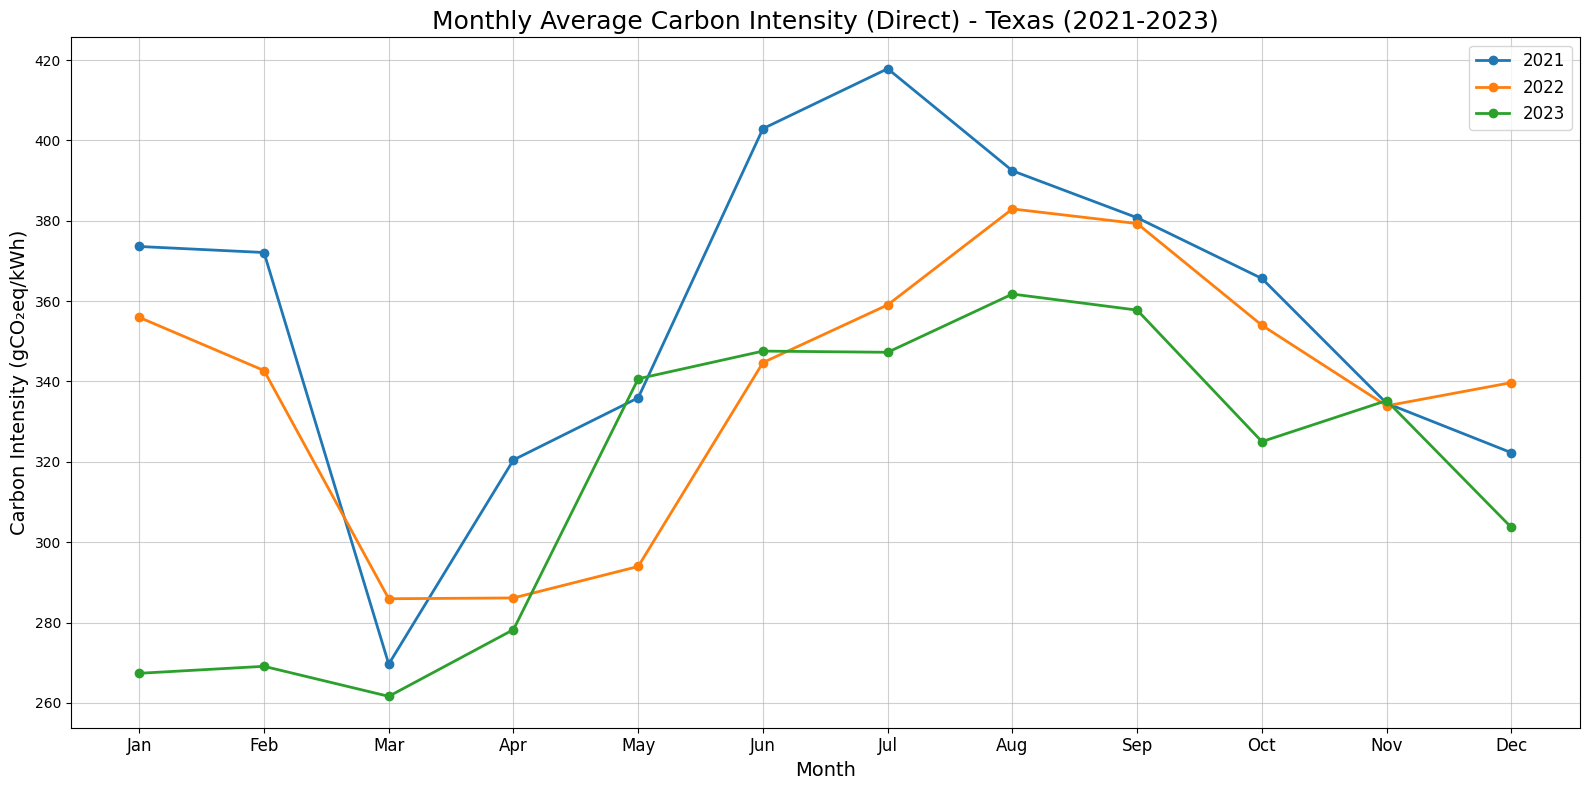

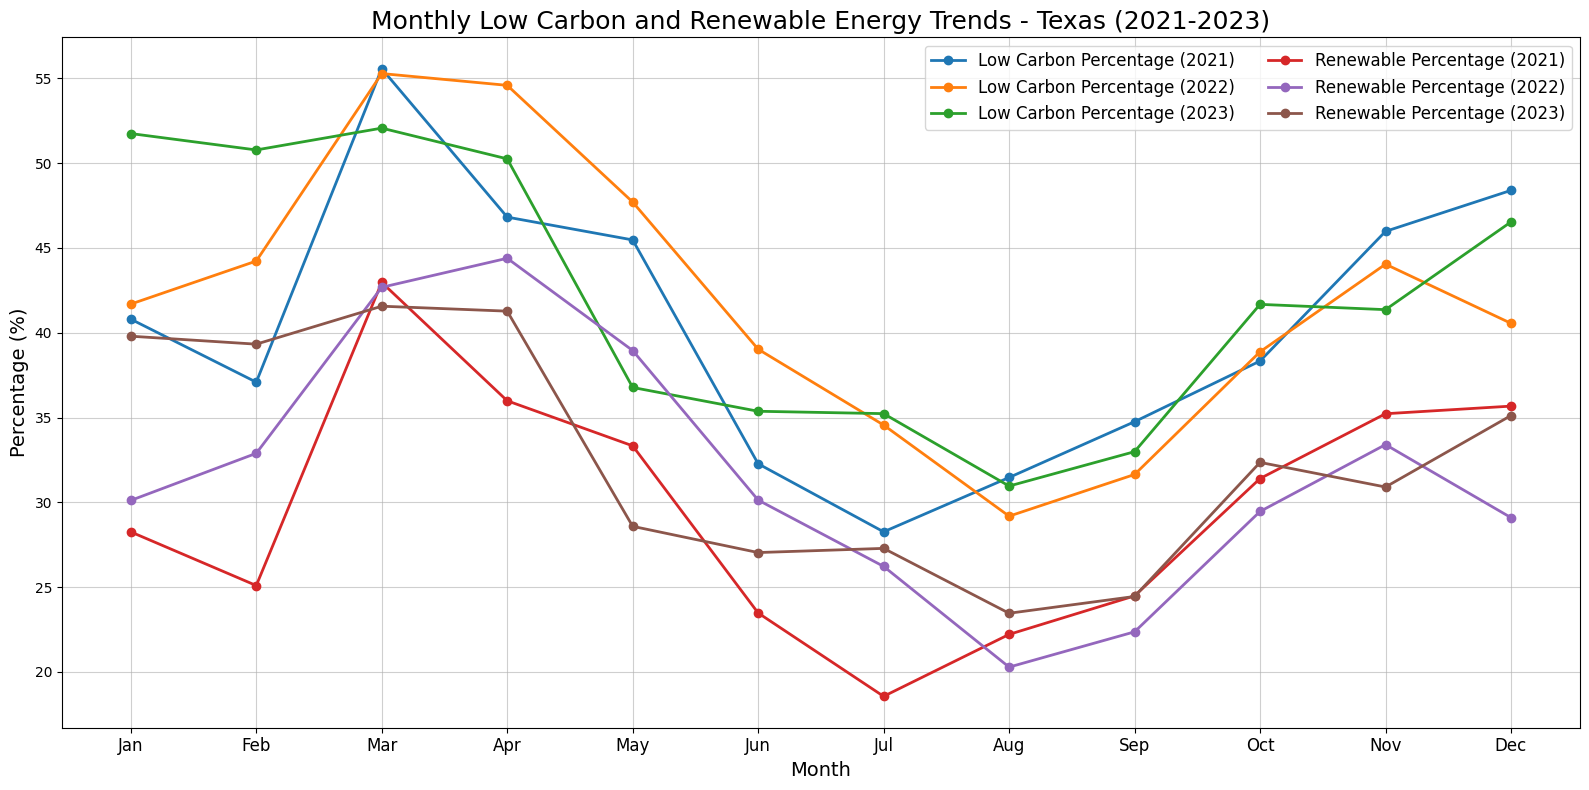

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets for Texas using the provided file paths
data_tx_2021 = pd.read_csv('/Users/aashrithasankineni/Downloads/texas_carbon_footprint/US-TEX-ERCO_2021_hourly.csv')
data_tx_2022 = pd.read_csv('/Users/aashrithasankineni/Downloads/texas_carbon_footprint/US-TEX-ERCO_2022_hourly.csv')
data_tx_2023 = pd.read_csv('/Users/aashrithasankineni/Downloads/texas_carbon_footprint/US-TEX-ERCO_2023_hourly.csv')

# Combine the datasets for all years
data_tx_combined = pd.concat([data_tx_2021, data_tx_2022, data_tx_2023], ignore_index=True)

# Convert Datetime column to datetime format
data_tx_combined['Datetime (UTC)'] = pd.to_datetime(data_tx_combined['Datetime (UTC)'])

# Extract Year and Month for grouping
data_tx_combined['Year'] = data_tx_combined['Datetime (UTC)'].dt.year
data_tx_combined['Month'] = data_tx_combined['Datetime (UTC)'].dt.month

# Select numeric columns
numeric_columns = [
    'Carbon Intensity gCO₂eq/kWh (direct)',
    'Low Carbon Percentage',
    'Renewable Percentage',
]

# Group by Year and Month, and calculate the mean
monthly_avg_tx = data_tx_combined.groupby(['Year', 'Month'])[numeric_columns].mean().reset_index()

# Pivot the data for Carbon Intensity plot
pivoted_data_tx = monthly_avg_tx.pivot(index='Month', columns='Year', values='Carbon Intensity gCO₂eq/kWh (direct)')

# Plot Carbon Intensity (Direct) trends for Texas
plt.figure(figsize=(16, 8))
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for year in pivoted_data_tx.columns:
    plt.plot(
        pivoted_data_tx.index,
        pivoted_data_tx[year],
        marker='o',
        label=f'{int(year)}',
        linewidth=2
    )

# Customize the plot
plt.title('Monthly Average Carbon Intensity (Direct) - Texas (2021-2023)', fontsize=18)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Carbon Intensity (gCO₂eq/kWh)', fontsize=14)
plt.xticks(range(1, 13), month_labels, fontsize=12)
plt.legend(fontsize=12, loc='upper right')
plt.grid(alpha=0.6)
plt.tight_layout()
plt.show()

# Plot Renewable and Low Carbon Percentage for Texas
plt.figure(figsize=(16, 8))
for col in ['Low Carbon Percentage', 'Renewable Percentage']:
    pivoted_data_tx = monthly_avg_tx.pivot(index='Month', columns='Year', values=col)
    for year in pivoted_data_tx.columns:
        plt.plot(
            pivoted_data_tx.index,
            pivoted_data_tx[year],
            marker='o',
            label=f'{col} ({int(year)})',
            linewidth=2
        )

# Customize the plot
plt.title('Monthly Low Carbon and Renewable Energy Trends - Texas (2021-2023)', fontsize=18)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.xticks(range(1, 13), month_labels, fontsize=12)
plt.legend(fontsize=12, loc='upper right', ncol=2)
plt.grid(alpha=0.6)
plt.tight_layout()
plt.show()
